# Tennis Prediction — Notebook MVP
Aquesta llibreta et guia pas a pas per executar el **pipeline v1** i veure mètriques, gràfics i prediccions.

**Requisits**: `pandas`, `numpy`, `scikit-learn`, `matplotlib`.

## 1) Paths i configuració bàsica

In [13]:

import os, sys, json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime

# On tens el script? Si l'has descarregat a la mateixa carpeta, ajusta aquesta ruta:
SCRIPT_PATH = "../tennis_model_pipeline_v1.py"  # canvia si cal
DATA_DIR = "."         # posa aquí la teva carpeta amb CSVs
OUT_DIR = "outputs"       # carpeta d'outputs

TRAIN_END = "2024-12-31"  # ajusta
VALID_END = "2025-08-31"  # ajusta

os.makedirs(OUT_DIR, exist_ok=True)
print('Ok: OUT_DIR =', OUT_DIR)


Ok: OUT_DIR = outputs


## 2) Importa el pipeline

In [14]:
import sys, os

# Afegeix la carpeta on hi ha el .py al PYTHONPATH
script_dir = os.path.abspath(os.path.join(os.path.dirname(SCRIPT_PATH), "."))
sys.path.insert(0, script_dir)

import tennis_model_pipeline_v1 as mod
print('OK, importat:', mod)
print('Funcions:', [x for x in dir(mod) if not x.startswith('_')][:15], '...')


OK, importat: <module 'tennis_model_pipeline_v1' from '/Users/adriaparcerisas/Downloads/tennis_model_pipeline_v1.py'>
Funcions: ['Dict', 'EloConfig', 'EloEngine', 'List', 'LogisticRegression', 'Optional', 'SURFACES', 'StandardScaler', 'Tuple', 'annotations', 'argparse', 'bayes_shrink', 'brier_score_loss', 'calibration_curve', 'compute_pre_match_features'] ...


## 3) Comprovació ràpida de dades

In [15]:

import pandas as pd, os

matches_path = os.path.join(DATA_DIR, "matches.csv")
points_path = os.path.join(DATA_DIR, "points_sets_games.csv")

if not os.path.exists(matches_path):
    print("⚠️ No trobo data/matches.csv. Opcionalment pots executar la cel·la següent per generar un MOCK petit.")
else:
    matches = pd.read_csv(matches_path)
    display(matches.head())
    print('Files:', len(matches))

if os.path.exists(points_path):
    points = pd.read_csv(points_path)
    display(points.head())
    print('Points files:', len(points))
else:
    points = None
    print("No hi ha points_sets_games.csv (opc).")


,match_id,date,tournament,city,country,level,round,best_of_5,surface,indoor,player_a_id,player_b_id,winner_id,duration_minutes,player_a_country,player_b_country
0,2018-339_1.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,MH30,PB22,MH30,95.0,AUS,CAN
1,2018-339_2.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,SU55,E831,E831,150.0,CAN,GBR
2,2018-339_3.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,MA30,CH27,CH27,99.0,LUX,KOR
3,2018-339_4.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,E690,TD51,E690,59.0,AUS,USA
4,2018-339_5.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,E873,Z184,Z184,72.0,MEX,ARG


Files: 21598


,match_id,player_id,aces,double_faults,first_sv_in,first_sv_pts_won,second_sv_pts_won,bp_faced,bp_saved,bp_opp,bp_conv,service_games,return_games,hold_games_won,break_games_won,tb_played,tb_won
0,2018-339_1.0_2018-01-01,MH30,8.0,0.0,37.0,27.0,17.0,1.0,1.0,10.0,3.0,9.0,9.0,9.0,3.0,NaN,NaN
1,2018-339_2.0_2018-01-01,E831,5.0,5.0,65.0,54.0,29.0,6.0,5.0,3.0,2.0,17.0,17.0,16.0,2.0,NaN,NaN
2,2018-339_3.0_2018-01-01,CH27,7.0,4.0,35.0,29.0,17.0,2.0,2.0,5.0,2.0,10.0,11.0,10.0,2.0,NaN,NaN
3,2018-339_4.0_2018-01-01,E690,7.0,1.0,32.0,23.0,11.0,3.0,2.0,5.0,4.0,9.0,8.0,8.0,4.0,NaN,NaN
4,2018-339_5.0_2018-01-01,Z184,12.0,3.0,37.0,31.0,11.0,1.0,1.0,6.0,2.0,10.0,9.0,10.0,2.0,NaN,NaN


Points files: 43302


### (Opcional) Genera un dataset MOCK minimal per provar el flux

In [16]:

# Executa només si no tens dades encara.
import pandas as pd, numpy as np, os
from datetime import datetime, timedelta
np.random.seed(0)

matches_path = os.path.join(DATA_DIR, "matches.csv")
if not os.path.exists(matches_path):
    os.makedirs(DATA_DIR, exist_ok=True)
    dates = pd.date_range("2022-01-01", periods=60, freq="7D")
    players = [f"P{i}" for i in range(1,9)]
    surfaces = ["hard","clay","grass","indoor-hard"]
    rows = []
    mid = 1
    for d in dates:
        a,b = np.random.choice(players, 2, replace=False)
        surf = np.random.choice(surfaces)
        winner = np.random.choice([a,b])
        rows.append({
            "match_id": f"M{mid}",
            "date": d.date().isoformat(),
            "tournament": "MockOpen",
            "city": "Nowhere",
            "country": "NA",
            "level": "250",
            "round": "R1",
            "best_of_5": 0,
            "surface": surf,
            "indoor": int(surf=="indoor-hard"),
            "player_a_id": a,
            "player_b_id": b,
            "winner_id": winner,
            "duration_minutes": int(np.random.randint(60,140))
        })
        mid += 1
    pd.DataFrame(rows).to_csv(matches_path, index=False)
    print("✅ Creat data/matches.csv mock (", len(rows), "files ).")

# Reload
matches = pd.read_csv(matches_path)
print("Matches ready:", matches.shape)
display(matches.head(3))


Matches ready: (21598, 16)


,match_id,date,tournament,city,country,level,round,best_of_5,surface,indoor,player_a_id,player_b_id,winner_id,duration_minutes,player_a_country,player_b_country
0,2018-339_1.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,MH30,PB22,MH30,95.0,AUS,CAN
1,2018-339_2.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,SU55,E831,E831,150.0,CAN,GBR
2,2018-339_3.0_2018-01-01,2018-01-01,Brisbane,Brisbane,AUS,ATP,R32,0,hard,0,MA30,CH27,CH27,99.0,LUX,KOR


## 4) Genera features pre-partit per jugador

In [17]:

feats_player_pre = mod.compute_pre_match_features(matches, points, tau_days=60.0, alpha_pct=30.0)
print("feats_player_pre:", feats_player_pre.shape)
display(feats_player_pre.head())
feats_player_pre.to_csv(os.path.join(OUT_DIR, "features_player_pre.csv"), index=False)


feats_player_pre: (43196, 24)


,match_id,date,surface,indoor,best_of_5,player_id,opponent_id,elo_global_pre,elo_surface_pre,opp_elo_surface_pre,...,break_pre,serve_return_sum_pre,rest_days_pre,matches_14d_pre,aces_pg_pre,dfs_pg_pre,tb_winrate_pre,first_in_pre,first_pts_pre,second_pts_pre
0,2025-M-DC-2025-WG2-R1-TOG-EGY-01_1.0_2025-09-13,2025-09-13,hard,0,0,000001,Z0BL,1500.0,1500.0,1500.0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-M-DC-2024-WG2-PO-TOG-INA-01_3.0_2024-02-03,2024-02-03,hard,0,0,133933,M0D4,1500.0,1500.0,1500.0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-M-DC-2024-WG2-PO-TOG-INA-01_2.0_2024-02-03,2024-02-03,hard,0,0,133933,SY76,1500.0,1500.0,1500.0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-M-DC-2024-WG2-M-TOG-LAT-01_1.0_2024-09-14,2024-09-14,hard,0,0,133933,R0JJ,1500.0,1500.0,1500.0,...,NaN,0,224.0,0,NaN,NaN,0.5,0.6,0.72,0.52
4,2024-M-DC-2024-WG2-M-TOG-LAT-01_3.0_2024-09-14,2024-09-14,hard,0,0,133933,T0HY,1500.0,1500.0,1500.0,...,NaN,0,224.0,0,NaN,NaN,0.5,0.6,0.72,0.52


## 5) Construeix dataset de partit (diferencials A–B)

In [9]:

dataset, model_cols = mod.make_match_features(feats_player_pre, matches)
print("dataset:", dataset.shape)
print("model_cols:", len(model_cols))
display(dataset.head(3))
dataset.to_csv(os.path.join(OUT_DIR, "dataset_match_level.csv"), index=False)


dataset: (24934, 26)
model_cols: 22


,match_id,date,surface,elo_global_pre_diff,elo_surface_pre_diff,winrate10_pre_diff,winrate25_pre_diff,sos_elo_recent_pre_diff,hold_pre_diff,break_pre_diff,...,first_in_pre_diff,first_pts_pre_diff,second_pts_pre_diff,is_indoor,is_best_of_5,surface_hard,surface_clay,surface_grass,surface_indoor-hard,y_home_win
0,2018-339_1.0_2018-01-01,2018-01-01,hard,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,1,0,0,0,1
1,2018-339_2.0_2018-01-01,2018-01-01,hard,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,1,0,0,0,0
2,2018-339_3.0_2018-01-01,2018-01-01,hard,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,1,0,0,0,0


In [22]:
os.makedirs("outputs", exist_ok=True)
pd.Series(model_cols).to_csv("outputs/model_columns.txt", index=False, header=False)
print("✅ Guardat outputs/model_columns.txt amb", len(model_cols), "features")


✅ Guardat outputs/model_columns.txt amb 22 features


## 6) Split temporal Train/Valid/Test

In [18]:

train, valid, test = mod.temporal_split(dataset, train_end=TRAIN_END, valid_end=VALID_END)
for name, df in [('train',train),('valid',valid),('test',test)]:
    print(name, df['date'].min(), '→', df['date'].max(), ' | n=', len(df))
assert len(train)>0 and len(valid)>0, "Revisa les dates TRAIN_END/VALID_END (no hi ha files suficients)."


train 2018-01-01 00:00:00 → 2024-12-29 00:00:00  | n= 18952
valid 2025-01-06 00:00:00 → 2025-08-24 00:00:00  | n= 4192
test 2025-09-12 00:00:00 → 2025-10-13 00:00:00  | n= 1790


## 7) Entrena Logistic baseline i mètriques

{
  "train_logloss": 0.6516302435158156,
  "valid_logloss": 0.6193274755514968,
  "valid_auc": 0.7268620928002447,
  "valid_brier": 0.2145468484602811
}
Calibration plot a: outputs/calibration_valid.png


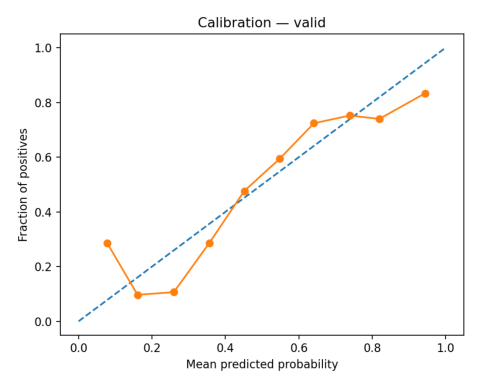

In [19]:

lr, scaler, metrics, p_va = mod.train_logistic_baseline(train, valid, model_cols, C=1.0, max_iter=200)
print(json.dumps(metrics, indent=2))

# Corba de calibració (valid)
fig_path = mod.evaluate_and_plot_calibration(valid['y_home_win'].values, p_va, OUT_DIR, tag="valid")
print("Calibration plot a:", fig_path)

# Mostra la imatge
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(fig_path)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()


## 8) Avaluació en TEST i guardar prediccions

In [20]:

from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

import numpy as np
X_te = scaler.transform(test[model_cols].fillna(0.0))
y_te = test['y_home_win'].values
p_te = lr.predict_proba(X_te)[:,1]

test_metrics = {
    'test_logloss': float(log_loss(y_te, p_te)) if len(np.unique(y_te))>1 else None,
    'test_auc': float(roc_auc_score(y_te, p_te)) if len(np.unique(y_te))>1 else None,
    'test_brier': float(brier_score_loss(y_te, p_te)),
}
print(json.dumps(test_metrics, indent=2))

preds = test[['match_id','date']].copy()
preds['p_home_win'] = p_te
preds['y'] = y_te
preds_path = os.path.join(OUT_DIR, "preds_test.csv")
preds.to_csv(preds_path, index=False)
preds.head()


{
  "test_logloss": 0.6518020628804759,
  "test_auc": 0.6470686868916957,
  "test_brier": 0.23031232311580643
}


,match_id,date,p_home_win,y
23144,2025-M-DC-2025-WG1-R1-KOR-KAZ-01_1.0_2025-09-12,2025-09-12,0.060681,0
23145,2025-M-DC-2025-WG1-R1-KOR-KAZ-01_2.0_2025-09-12,2025-09-12,0.201884,1
23146,2025-M-DC-2025-WG1-R1-KOR-KAZ-01_3.0_2025-09-12,2025-09-12,0.899685,0
23147,2025-M-DC-2025-WG1-R1-CAN-ISR-01_1.0_2025-09-12,2025-09-12,0.360726,0
23148,2025-M-DC-2025-WG1-R1-CAN-ISR-01_2.0_2025-09-12,2025-09-12,0.328198,0


## 9) Importància de variables (coeficients del Logistic)

In [21]:

import pandas as pd
coefs = pd.DataFrame({'feature': model_cols, 'coef': lr.coef_.ravel()})
coefs.sort_values('coef', ascending=False).head(12)


,feature,coef
3,winrate25_pre_diff,0.422655
9,matches_14d_pre_diff,0.128199
2,winrate10_pre_diff,0.124103
18,surface_hard,0.013349
20,surface_grass,0.006963
0,elo_global_pre_diff,0.000000
1,elo_surface_pre_diff,0.000000
15,second_pts_pre_diff,0.000000
14,first_pts_pre_diff,0.000000
13,first_in_pre_diff,0.000000
